In [1]:
import os
import numpy as np

base_dir = './scaleogram'

data_list = []
label_list = []

label_mapping = {
    'df_eyem_musc': 0,
    'df_musc_elec': 1
}

max_files_per_category = 80
file_counts = {'df_eyem_musc': 0, 'df_musc_elec': 0}

for label_name, label in label_mapping.items():
    label_dir = os.path.join(base_dir, label_name)
    
    if not os.path.isdir(label_dir):
        continue
    
    for file_name in os.listdir(label_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(label_dir, file_name)
            
            scaleogram = np.load(file_path)
            
            data_list.append(scaleogram)
            label_list.append(label)
            
            file_counts[label_name] += 1
            
            if file_counts[label_name] >= max_files_per_category:
                break

data_array = np.array(data_list)
labels_array = np.array(label_list)

print(f"Shape of data_array: {data_array.shape}")
print(f"Shape of labels_array: {labels_array.shape}")

Shape of data_array: (160, 19, 238, 750)
Shape of labels_array: (160,)


Usando dispositivo: cuda
Entrenamiento: 128 muestras
Validación: 32 muestras
EEG_CNN(
  (conv1): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(5, 5))
  (fc1): Linear(in_features=3200, out_features=256, bias=True)
  (dro

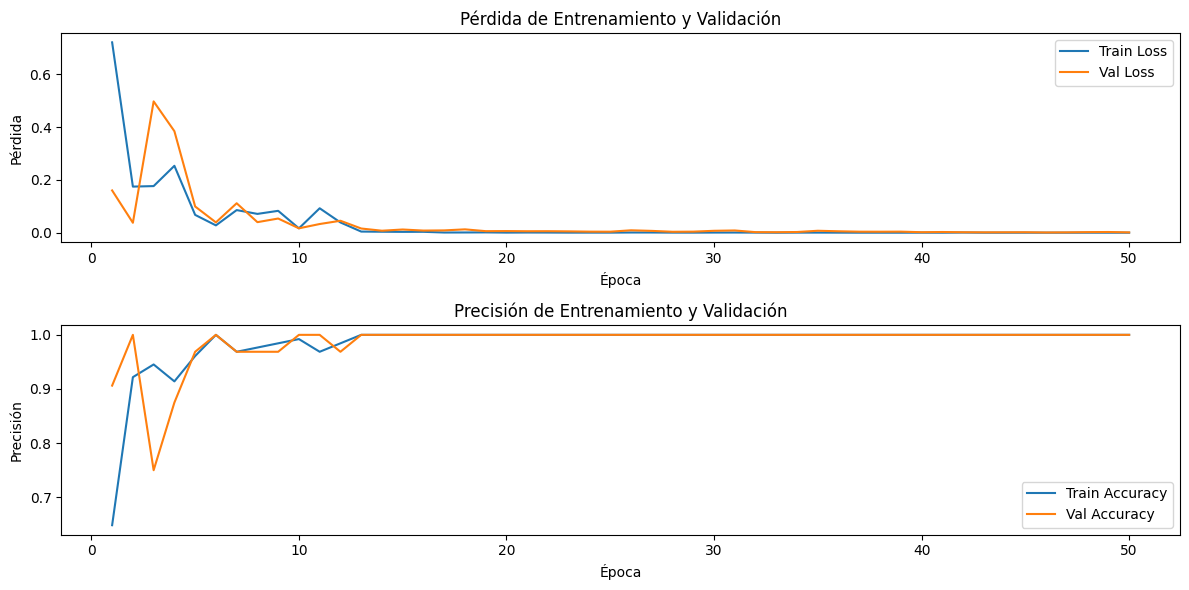

Precisión en Validación: 1.0000
Matriz de Confusión:
[[15  0]
 [ 0 17]]
Reporte de Clasificación:
              precision    recall  f1-score   support

   eyem_musc       1.00      1.00      1.00        15
   musc_elec       1.00      1.00      1.00        17

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

data_tensor = torch.tensor(data_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)

data_tensor = (data_tensor - data_tensor.mean(dim=(1,2,3), keepdim=True)) / data_tensor.std(dim=(1,2,3), keepdim=True)

class EEGDataset(Dataset):
    def __init__(self, data, labels):
        """
        Args:
            data (torch.Tensor): Tensor de datos con forma (samples, channels, frequencies, time).
            labels (torch.Tensor): Tensor de etiquetas con forma (samples,).
        """
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = EEGDataset(data_tensor, labels_tensor)

train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
val_size = len(dataset) - train_size  # 20% para validación
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Entrenamiento: {len(train_dataset)} muestras")
print(f"Validación: {len(val_dataset)} muestras")

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class EEG_CNN(nn.Module):
    def __init__(self):
        super(EEG_CNN, self).__init__()
        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=19, out_channels=32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2))

        self.adaptive_pool = nn.AdaptiveAvgPool2d((5,5)) 
        
        self.fc1 = nn.Linear(128 * 5 * 5, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = EEG_CNN().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero grad
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward 
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calcular las predicciones
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validación
        model.eval()
        val_running_loss = 0.0
        all_preds = []
        all_labels = []
        running_corrects_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_corrects_val += torch.sum(preds == labels.data)
                total_val += labels.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects_val.double() / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_loss:.4f} - "
              f"Train Acc: {epoch_acc:.4f} - "
              f"Val Loss: {epoch_val_loss:.4f} - "
              f"Val Acc: {epoch_val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

num_epochs = 50
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.subplot(2,1,2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    acc = running_corrects.double() / total
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=['eyem_musc', 'musc_elec'])

    print(f"Precisión en Validación: {acc:.4f}")
    print("Matriz de Confusión:")
    print(cm)
    print("Reporte de Clasificación:")
    print(cr)

evaluate_model(model, val_loader)
